In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#import argparse
from pathlib import Path
import math
from scipy.integrate import odeint

from matplotlib import rc
rc('text', usetex=True) # Use LaTeX font

In [ ]:
def bump_function(x, center=0):
    if x <= center-1 or x >= center + 1:
        return 0
    else:
        return np.exp(-(1/(1-np.power(x-center, 2))))

def ic_function(x, b, xf, c):
    return b + (1-b)/(1 + np.exp(1/c * (x - xf), dtype='double'))

class Topography:
    def __init__(self, function_type, center=0):
        self.function_type = function_type
        self.center = center

    def eval(self, x):
        if self.function_type == "bump":
            return bump_function(x, self.center)
        if self.function_type == "plane":
            return 0

def ode_system(h, s, D, alpha, dx):
    def phi(i):
        return h[i] + s.eval(i*dx)
    def interp(i):
            # An interpolation for h^3
            #return 2 * (np.power(h[k]*h[k-1], 2)/(h[k] + h[k+1]))
            return 1/2 * (np.power(h[i], 3, dtype=np.float64) + np.power(h[i+1], 3, dtype=np.float64))
    def f1(i):
        #return (1/(2*np.power(dx, 2))) * ((np.power(h[i-1], 3) + np.power(h[i], 3))*(np.power(phi(i-1), 3) - np.power(phi(i), 3)) + (np.power(h[i], 3) + np.power(h[i+1], 3))*(np.power(phi(i+1), 3) - np.power(phi(i), 3)))
        return (1/(2*np.power(dx, 2))) * ((np.power(h[i-1], 3) + np.power(h[i], 3))*(phi(i-1) - phi(i)) + (np.power(h[i], 3)+np.power(h[i+1], 3))*(phi(i+1)-phi(i)))
    def f2(i):
        return (1/np.power(dx, 4)) * (interp(i-1)*(phi(i-2)-3*phi(i-1)+3*phi(i)-phi(i+1)) + interp(i)*(-phi(i-1)+3*phi(i)-3*phi(i+1)+phi(i+2)))
    def f3(i):
        #return (1/(4*dx)) * ((np.power(h[i+1], 2) + np.power(h[i], 2))*(h[i+1]+h[i]) - (np.power(h[i], 2) + np.power(h[i-1], 2))*(h[i]+h[i-1]))
        return (1/(2*dx)) * (np.power(h[i+1], 3) - np.power(h[i-1], 3))
    def f(i):
        if i == 0 or i == len(h)-1 or i == len(h)-2 or i == len(h)-3:
            return 0
        return D*np.cos(alpha)*f1(i) - f2(i) - np.sin(alpha)*f3(i)

    return np.array([f(i) for i in range(0, len(h))])
    
def rk4(h, s, D, alpha, dt, dx):
    k1 = ode_system(h, s, D, alpha, dx)
    k2 = ode_system(h + (dt/2)*k1, s, D, alpha, dx)
    k3 = ode_system(h + (dt/2)*k2, s, D, alpha, dx)
    k4 = ode_system(h + dt*k3, s, D, alpha, dx)
    return h + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

def forward_euler(h, s, D, alpha, dt, dx):
    return h + dt*ode_system(h, s, D, alpha, dx)

def run(init_conds, s, D, alpha, tmax, dt, dx):
    ret = [init_conds]
    t = np.arange(0, tmax+dt, dt)
    for i in range(len(t) - 1):
        u = ret[-1]
        ret.append(forward_euler(u, s, D, alpha, dt, dx))
    return (ret, t)

In [ ]:
s = Topography('plane')
nx = 100
Lx = 20
dx = Lx/nx
b = 0.1
D = 0
alpha = np.pi/6
tmax = 5
dt = 1/(2**10)
#dt = np.power(dx, 4)

fig, ax = plt.subplots()

x = np.arange(0, Lx, dx)
init_conds = ic_function(x, b, 5, 0.5)
init_conds = np.append(init_conds, [[init_conds[-1]], [init_conds[0]]])

sys, t = run(init_conds, s, D, alpha, tmax, dt, dx)
sys = np.asarray(sys)

def plots(x, sys, tmax, dt, deltat):
    for i in np.arange(0, tmax+deltat, deltat):
        idx = int(i * tmax/dt)
        plt.plot(x, sys[idx][:-2])

plots(x, sys, tmax, dt, 0.5)
plt.xlabel(r'$x$')
plt.ylabel(r'$h$')
#plots(x, sys, tmax, dt, 2)
#plt.savefig("../images/test", dpi=200)

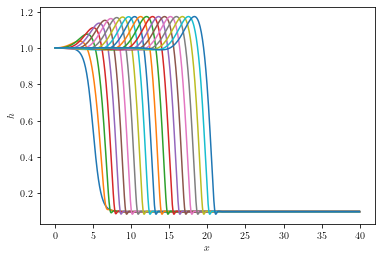

In [187]:
from scipy.integrate import solve_ivp
from pathlib import Path
from datetime import datetime

def bump_function(x, center=0):
    if x <= center-1 or x >= center + 1:
        return 0
    else:
        return np.exp(-(1/(1-np.power(x-center, 2))))

def ic_function(x, b, xf, c):
    return b + (1-b)/(1 + np.exp(1/c * (x - xf), dtype='double'))

class Topography:
    def __init__(self, function_type, center=0):
        self.function_type = function_type
        self.center = center

    def eval(self, x):
        if self.function_type == "bump":
            return bump_function(x, self.center)
        if self.function_type == "plane":
            return 0

# h = (h_0, h_1, ..., h_nx, h_nx+1, h_-1)
def H(t, h, dx, s, D, alpha):
    def phi(i):
        return h[i] + s.eval(i*dx)
    def interp(i):
        # An interpolation of h^3
        return 1/2 * (np.power(h[i], 3) + np.power(h[i+1], 3))
    def f1(i):
        return 1/(dx**2) * (interp(i-1)*(phi(i-1) - phi(i)) + interp(i)*(phi(i+1) - phi(i)))
    def f2(i):
        return (1/dx**4) * (interp(i-1)*(phi(i-2) - 3*phi(i-1) + 3*phi(i) - phi(i+1)) + interp(i)*(-phi(i-1) + 3*phi(i) - 3*phi(i+1) + phi(i+2)))
    def f3(i):
        return (1/(2*dx)) * (np.power(h[i+1], 3) - np.power(h[i-1], 3))
    def f(i):
        if i == 0 or i == len(h)-1 or i == len(h)-2 or i == len(h)-3:
            return 0
        if alpha == np.pi/2:
            return -(f2(i) + f3(i))
        elif alpha == 0:
            return D**f1(i) - f2(i)
        else:
            return D*np.cos(alpha)*f1(i) - f2(i) - np.sin(alpha)*f3(i)

    return np.array([f(i) for i in range(0, len(h))])

s = Topography('plane')
nx = 800
Lx = 40
dx = Lx/nx
b = 0.1
D = 1
alpha = np.pi/4

fig, ax = plt.subplots()

x = np.arange(0, Lx, dx)
init_conds = ic_function(x, b, 5, 0.5)
init_conds = np.append(init_conds, [[init_conds[-1]], [init_conds[0]]])

tspan = np.arange(0, 21, 1) 
sol = solve_ivp(H, [tspan[0], tspan[-1]], init_conds, method='LSODA', args=(dx, s, D, alpha), atol=1e-4, t_eval=tspan)

sys = sol.y.T

def plots(x, sys):
    for i in range(sys.shape[0]):
        plt.plot(x, sys[i][:-2])

plt.xlabel(r'$x$')
plt.ylabel(r'$h$')
plots(x, sys)


now = datetime.now()
dt_string = now.strftime("%m%d%Y-%H%M%S")
Path("../runs/%s" % dt_string).mkdir(parents=True, exist_ok=True)

plt.savefig("../runs/%s/plot" % dt_string, dpi=200)
np.save("../runs/%s/data" % dt_string, sys)
np.save("../runs/%s/times" % dt_string, sol.t)
    

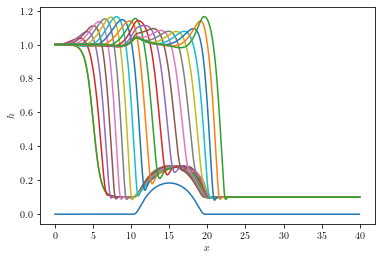

In [222]:
import math

def bump_function(x, c=1, center=0):
    if x <= center-c or x >= center+c:
        return 0
    else:
        return 1/2 * math.exp(-(c**2/(c**2-math.pow(x-center, 2))))

def ic_function(x, b, xf, c, s):
    return b + (1-b)/(1 + np.exp(1/c * (x - xf), dtype='double')) + s.eval(x)

class Topography:
    def __init__(self, function_type, center=0):
        self.function_type = function_type
        self.center = center

    def eval(self, x):
        if self.function_type == "bump":
            bump_vec = np.vectorize(bump_function, otypes=[float])
            return bump_vec(x, c=5, center=self.center)
        if self.function_type == "plane":
            return 0

    def __call__(self, x):
        return eval(self, x)

def H(t, h, dx, s, D, alpha):
    def phi(i):
        return h[i] + s.eval(i*dx)
    def interp(i):
        # An interpolation of h^3
        return 1/2 * (np.power(h[i], 3) + np.power(h[i+1], 3))
    def f1(i):
        return 1/(dx**2) * (interp(i-1)*(phi(i-1) - phi(i)) + interp(i)*(phi(i+1) - phi(i)))
    def f2(i):
        return (1/dx**4) * (interp(i-1)*(phi(i-2) - 3*phi(i-1) + 3*phi(i) - phi(i+1)) + interp(i)*(-phi(i-1) + 3*phi(i) - 3*phi(i+1) + phi(i+2)))
    def f3(i):
        return (1/(2*dx)) * (np.power(h[i+1], 3) - np.power(h[i-1], 3))
    def f(i):
        if i == 0 or i == len(h)-1 or i == len(h)-2 or i == len(h)-3:
            return 0
        if alpha == np.pi/2:
            return -(f2(i) + f3(i))
        elif alpha == 0:
            return D**f1(i) - f2(i)
        else:
            return D*np.cos(alpha)*f1(i) - f2(i) - np.sin(alpha)*f3(i)

    return np.array([f(i) for i in range(0, len(h))])

s = Topography('bump', center=15)
nx = 800
Lx = 40
dx = Lx/nx
b = 0.1
D = 1
alpha = np.pi/4

x = np.arange(0, Lx, dx)
init_conds = ic_function(x, b, 5, 0.5, s)
init_conds = np.append(init_conds, [[init_conds[-1]], [init_conds[0]]])

fig, ax = plt.subplots()

tspan = np.arange(0, 21, 1) 

plt.plot(x, s.eval(x))
plt.plot(x, init_conds[:-2])

sol = solve_ivp(H, [tspan[0], tspan[-1]], init_conds, method='BDF', args=(dx, s, D, alpha), atol=1e-4, t_eval=tspan)

sys = sol.y.T

def plots(x, sys):
    for i in range(sys.shape[0]):
        plt.plot(x, sys[i][:-2])

plt.xlabel(r'$x$')
plt.ylabel(r'$h$')
plots(x, sys)


now = datetime.now()
dt_string = now.strftime("%m%d%Y-%H%M%S")
Path("../runs/%s" % dt_string).mkdir(parents=True, exist_ok=True)

plt.savefig("../runs/%s/plot" % dt_string, dpi=200)
np.save("../runs/%s/data" % dt_string, sys)
np.save("../runs/%s/times" % dt_string, sol.t)

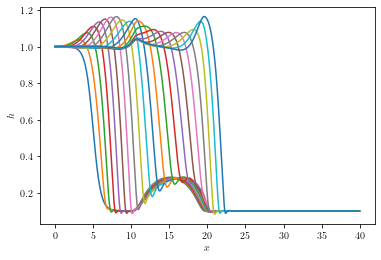

In [226]:
with open('../runs/02222022-065248/data.npy', 'rb') as f:
    sys = np.load(f)

def plots(x, sys):
    for i in range(sys.shape[0]):
        plt.plot(x, sys[i][:-2])

s = Topography('bump', center=15)
nx = 800
Lx = 40
dx = Lx/nx
b = 0.1

x = np.arange(0, Lx, dx)

plt.xlabel(r'$x$')
plt.ylabel(r'$h$')
plots(x, sys)
plt.savefig("../runs/02222022-065248/plot_no_topo", dpi=200)
